### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
# !wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip

In [11]:
import numpy as np
import cv2

IMG_HEIGHT = 600
#SIGN_SIZE = (224, 224)
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [12]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('../FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('../FullIJCNN2013', range(600,900), range(852,1213))

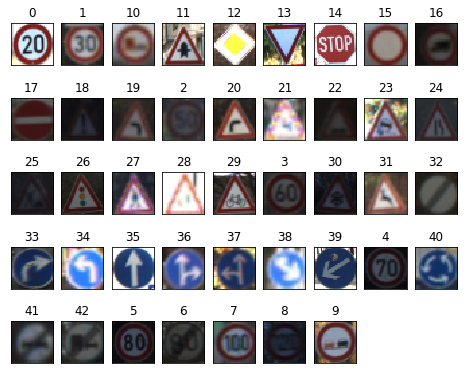

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [15]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

cnn = Sequential()
## If You preprocessed with gray scaling and local histogram equivalization then input_shape = (32,32,1) else (32,32,3)
cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
#cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.7))
cnn.add(Dense(num_classes, activation='softmax'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 128)         512       
__________

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

data = cnn.fit(tr_signs, tr_labels, batch_size=16, epochs=100, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard, early_stopping])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/100
 - 1s - loss: 5.8477 - acc: 0.0450 - val_loss: 3.9932 - val_acc: 0.1270
Epoch 2/100
 - 1s - loss: 4.9763 - acc: 0.0700 - val_loss: 3.4597 - val_acc: 0.1627
Epoch 3/100
 - 1s - loss: 4.6108 - acc: 0.1300 - val_loss: 3.3540 - val_acc: 0.1389
Epoch 4/100
 - 1s - loss: 3.9968 - acc: 0.1550 - val_loss: 3.0659 - val_acc: 0.2262
Epoch 5/100
 - 1s - loss: 3.6438 - acc: 0.2067 - val_loss: 2.8422 - val_acc: 0.3294
Epoch 6/100
 - 1s - loss: 3.1978 - acc: 0.2367 - val_loss: 3.4296 - val_acc: 0.1905
Epoch 7/100
 - 1s - loss: 2.8206 - acc: 0.3083 - val_loss: 2.6153 - val_acc: 0.3214
Epoch 8/100
 - 1s - loss: 2.6535 - acc: 0.3017 - val_loss: 2.6427 - val_acc: 0.2937
Epoch 9/100
 - 1s - loss: 2.3887 - acc: 0.3817 - val_loss: 2.1237 - val_acc: 0.4444
Epoch 10/100
 - 1s - loss: 2.2747 - acc: 0.3900 - val_loss: 1.8559 - val_acc: 0.5040
Epoch 11/100
 - 1s - loss: 2.1173 - acc: 0.4033 - val_loss: 1.6968 - val_acc: 0.5476
Epoch 12/100
 - 1s - loss: 1

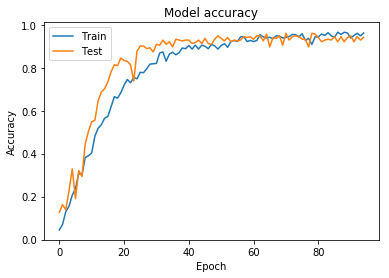

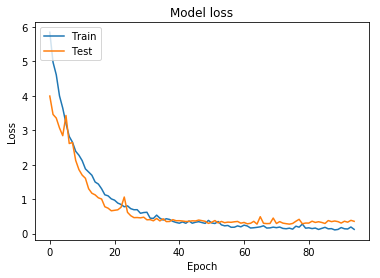

In [23]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# serialize model to JSON
model_json = cnn.to_json()
with open("classification_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("classification_model.h5")
print("Saved model to disk")

Saved model to disk


600
1200


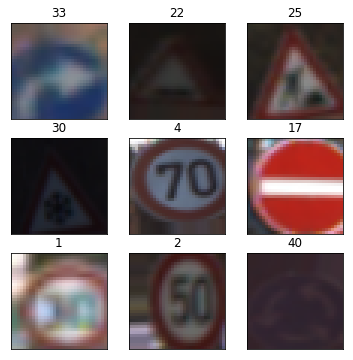

Epoch 1/100
 - 2s - loss: 1.6960 - acc: 0.6108 - val_loss: 0.4976 - val_acc: 0.8810
Epoch 2/100
 - 2s - loss: 1.2931 - acc: 0.6683 - val_loss: 0.4035 - val_acc: 0.9206
Epoch 3/100
 - 2s - loss: 1.1772 - acc: 0.6750 - val_loss: 0.3055 - val_acc: 0.9484
Epoch 4/100
 - 2s - loss: 0.9875 - acc: 0.7467 - val_loss: 0.3465 - val_acc: 0.9365
Epoch 5/100
 - 2s - loss: 0.9691 - acc: 0.7308 - val_loss: 0.3522 - val_acc: 0.9405
Epoch 6/100
 - 2s - loss: 0.8893 - acc: 0.7417 - val_loss: 0.3352 - val_acc: 0.9405
Epoch 7/100
 - 2s - loss: 0.8608 - acc: 0.7600 - val_loss: 0.3312 - val_acc: 0.9444
Epoch 8/100
 - 2s - loss: 0.8233 - acc: 0.7558 - val_loss: 0.3552 - val_acc: 0.9365
Epoch 9/100
 - 2s - loss: 0.7780 - acc: 0.7750 - val_loss: 0.3783 - val_acc: 0.9286
Epoch 10/100
 - 2s - loss: 0.6548 - acc: 0.8017 - val_loss: 0.3185 - val_acc: 0.9444
Epoch 11/100
 - 2s - loss: 0.7005 - acc: 0.7842 - val_loss: 0.3425 - val_acc: 0.9365
Epoch 12/100
 - 2s - loss: 0.5752 - acc: 0.8383 - val_loss: 0.3478 - val_a

In [25]:
from keras.preprocessing.image import ImageDataGenerator

print(len(tr_signs))
tr_signs_aug = np.array(tr_signs, copy=True) 
tr_labels_aug = np.array(tr_labels, copy=True)

#datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(tr_signs_aug, augment=True)

# Concatenating the old data with the augmented data
tr_signs_aug  = np.concatenate((tr_signs, tr_signs_aug), axis=0)
tr_labels_aug  = np.concatenate((tr_labels, tr_labels_aug), axis=0)

print(len(tr_signs_aug))

for x_batch, y_batch in datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs_aug) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs_aug, tr_labels_aug, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard, early_stopping])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

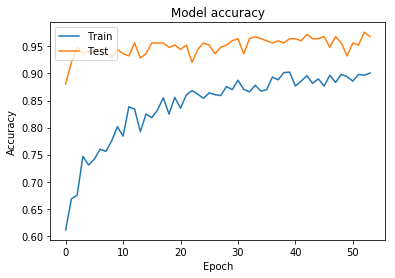

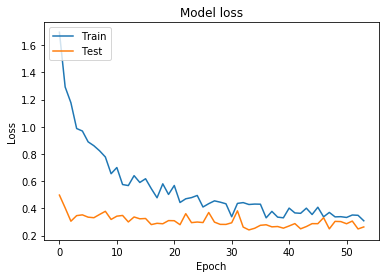

In [26]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()